# Examples of ATE calculation

In this notebook we'll see 3 examples of ATE calculation, and possible issues:
1. Example where having an unmeasured hidden confounder results in misleading estimation of ATE, even when there is good prediction accuracy
2. Example where regularzation on high dimension problem makes the estimated treatment effect in a regression model go wrong
3. Example of training two models, one on each treatment arm, and getting estimation of ATE

In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline

## Example where having an unmeasured hidden confounder results in misleading estimation of ATE, even when there is good prediction accuracy:

In this example, we'll sample $n = 100000$ vectors each with $d_{obs}=50$ observed confunders, and $d_{hidden}=1$ hidden confunder ($d = d_{obs} + d_{hidden} = 51$).<br>
The confunders are sampled from uniform distrubtion $ d_i \sim U\{-1,1\} $.

We also set the hidden confounder "weight", that we mark as $\alpha$ (e.g. in this case we set $\alpha = 10$)

In [2]:
n = 100000  #number of samples
d_obs = 50 #dimension of observed counfounders
d_hid = 1 #dimension of hidden confounders


In [3]:
#Confounders
#Create observed and hidden covariates taking values in {-1,1}
Xobs = 2*(np.random.randint(2, size=(d_obs,n)))-1
Xhid = 2*(np.random.randint(2, size=(d_hid,n)))-1


In [4]:
#Hidden confounding strength parameters
#Vary value to explore its effect: try 0,1,5,10
alpha = 10
hid_conf_treat = alpha
hid_conf_outcome = alpha

In this section we calculate the treatment assignments. <br>
First, we estimate the propensity score : $ e(X)= P(T=1\mid X) = \frac{1}{1+\exp(-l)}$   
where $l=w_{obs} \cdot X_{obs} + w_{hidden} \cdot X_{hidden}$ <br>
$w_{obs}^i = \frac{z}{\sqrt{d_{obs}}}  $ <br>
$w_{hid}^i = \alpha $ <br>
where $z \sim \mathcal{N}(0,1)$ 


Than, we set the treatment assignments :
$     T=\left\{
                \begin{array}{ll}
                  1 & \mathcal{u} < e(x)  \\
                  0 & o.w.  \\
                \end{array}
              \right. $

where after it, we generate the outcomes, similarly to the confounders generation.

Where: <br>
$Y_0 = w_{obs} \cdot X_{obs}$ <br>
$Y_1 = w_{obs} \cdot X_{obs} + \alpha \cdot X_{hid}$ <br>

In [5]:
#Treatment assignemt
obs_assignment_weights = np.random.randn(d_obs,) /np.sqrt(d_obs) 
hid_assignment_weights = hid_conf_treat*np.ones(1,)

logit_propensity_score_obs = np.dot(obs_assignment_weights,Xobs)
logit_propensity_score_hid = np.dot(hid_assignment_weights,Xhid)

logit_propensity_score = logit_propensity_score_obs + logit_propensity_score_hid
propensity_score = expit(logit_propensity_score)

t = np.random.rand(n,) < propensity_score #Sample treatments

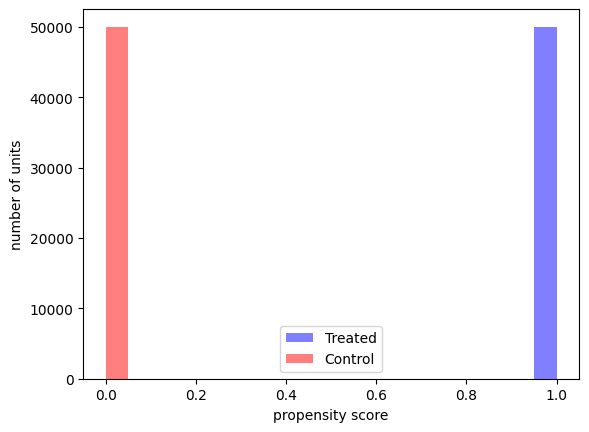

In [6]:
#Plot histogram of TRUE propensity scores (incl. hidden confounder)
#Note how this histogram changes for various values of alpha
treat_plt = plt.hist(propensity_score[t==1], fc=(0, 0, 1, 0.5),bins=20,label='Treated')
cont_plt = plt.hist(propensity_score[t==0],fc=(1, 0, 0, 0.5),bins=20,label='Control')
plt.legend();
plt.xlabel('propensity score');
plt.ylabel('number of units');

#plt.savefig('prop_score',format='pdf')

In [7]:
#Generate outcome
obs_outcome_weights = np.random.randn(d_obs,)/np.sqrt(d_obs)
hid_outcome_weights = hid_conf_outcome*np.ones(1,)

Y0 = np.dot(obs_outcome_weights,Xobs) 
Y1 = np.dot(obs_outcome_weights,Xobs) + np.dot(hid_outcome_weights,Xhid) 
#Note how hidden confounder acts on Y1

Yobs = (1-t)*Y0 + t*Y1

We regress on the observed confounders to get the outcome, using least-sequares method.

In the example, the true $ATE=  0$. <br>
we can estimate the true sample $ATE_{sample} = \mathop{\mathbb{E}}[Y_1 -Y_0]$ <br>
and $\widehat{ATE}$ estimated from the model is the weight of $t$ in the regressio model. 


We can see that altough the regression model is well fitted $(R^2 = 0.99)$, we got that $\widehat{ATE}=\alpha$ <br>
i.e. the hidden confunder affect

In [8]:
features = np.vstack((Xobs,t))
lin_model = np.linalg.lstsq(features.transpose(),Yobs, rcond=None)
weights = lin_model[0]

In [9]:
ATE_hat = weights[-1]
ATE_sample_true = np.mean(Y1-Y0)


print('estimated ATE from covariate adjustment is: \n {} \n'.format(ATE_hat))
print('true sample ATE is: \n {}'.format(ATE_sample_true))
print('true ATE is: \n {}'.format(0))

estimated ATE from covariate adjustment is: 
 9.997966840814524 

true sample ATE is: 
 -0.0104
true ATE is: 
 0


In [10]:
Yhat = np.dot(weights,features)
mean_abs_Y = np.mean(np.abs(Yobs))
RMSE = np.sqrt(np.mean((Yhat-Yobs)**2)) 
corrYYhat = np.corrcoef(Yobs,Yhat)[0,1]

print ('mean absolute Y is: \n {} \n'.format(mean_abs_Y))
print ('RMSE Yhat and Y: \n {} \n'.format(RMSE))
print ('r^2 between Y and Yhat is: \n {} \n'.format(corrYYhat**2))

mean absolute Y is: 
 5.381681219161659 

RMSE Yhat and Y: 
 0.14137972906349394 

r^2 between Y and Yhat is: 
 0.9992297105279289 



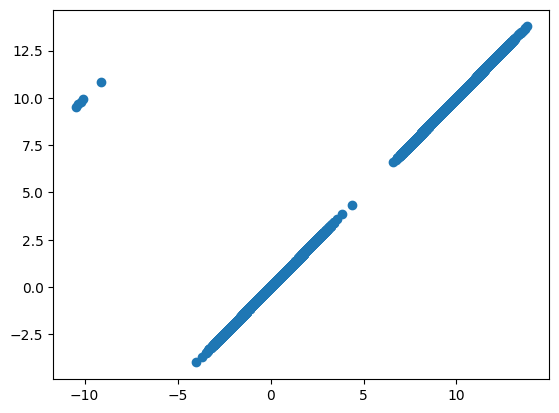

In [11]:
plt.scatter(Yobs, Yhat);

## Example where regularzation on high dimension problem makes the estimated treatment effect in a regression model go wrong

in here the sampled confounders vector consist only from observed confoundrs ($d = d_{obs} = 500$), 
where the confunders are sampled from uniform distrubtion $ d_i \sim U\{-5,5\} $.

The treatment assigment and the outcomes genrated as in the first part, <br>
where the only different is the treatment effect is fixed to be 0.3


In [12]:
d_obs = 500 #dimension of observed counfounders

#Confounders
#Create observed covariates taking values in {-5, 5}
Xobs = 2*(np.random.randint(6, size=(d_obs,n)))-5


In [13]:
#Treatment assignemt
obs_assignment_weights = np.random.randn(d_obs,) /np.sqrt(d_obs) 

logit_propensity_score_obs = np.dot(obs_assignment_weights,Xobs)

logit_propensity_score = logit_propensity_score_obs
propensity_score = expit(logit_propensity_score)

t = np.random.rand(n,) < propensity_score #Sample treatments

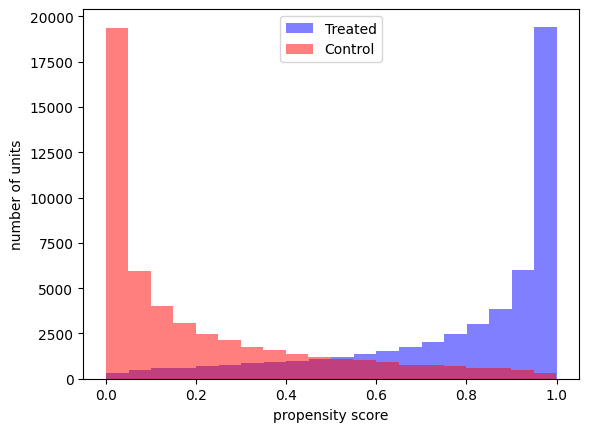

In [14]:
#Plot histogram of TRUE propensity scores
treat_plt = plt.hist(propensity_score[t==1], fc=(0, 0, 1, 0.5),bins=20,label='Treated')
cont_plt = plt.hist(propensity_score[t==0],fc=(1, 0, 0, 0.5),bins=20,label='Control')
plt.legend();
plt.xlabel('propensity score');
plt.ylabel('number of units');

In [15]:
#Generate outcome
obs_outcome_weights = np.random.randn(d_obs,)/np.sqrt(d_obs)

treat_effect = 0.3 

Y0 = np.dot(obs_outcome_weights,Xobs) 
Y1 = np.dot(obs_outcome_weights,Xobs) + treat_effect
#Note how hidden confounder acts on Y1

Yobs = (1-t)*Y0 + t*Y1

features = np.vstack((Xobs,t))


Using Lasso regression, with L1 regularizer (with $\alpha = 0.1$) <br>

Where we can see that the model predicts really well ($R^2 = 0.97$),<br>
but again we got $\widehat{ATE}=0$ (due to regularization)


In [16]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)

lasso_reg.fit(features.transpose(), Yobs);
weights = lasso_reg.coef_;


In [17]:
y_hat = lasso_reg.predict(features.transpose())

print("The R^2 of the prediction: {:.2} ".format(lasso_reg.score(features.transpose(), Yobs)))



The R^2 of the prediction: 0.97 


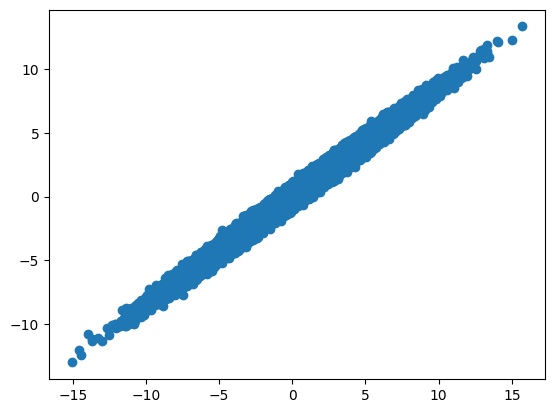

In [18]:
plt.scatter(Yobs, y_hat);


In [19]:
ATE_hat = weights[-1]
ATE_sample_true = np.mean(Y1-Y0)


print('estimated ATE from covariate adjustment is: \n {} \n'.format(ATE_hat))
print('true sample ATE is: \n {}'.format(ATE_sample_true))
print('true ATE is: \n {}'.format(treat_effect))

estimated ATE from covariate adjustment is: 
 0.0 

true sample ATE is: 
 0.2999999999999999
true ATE is: 
 0.3


## Example of training two models, one on each treatment arm, and getting estimation of ATE

In this section, we can see an example where we use the same high dimentional probelm as above. <br>
The difference is that now we train two Lasso models $(f_0, f_1)$, one for each group $(T=0, T=1)$.

We will fit each model using samples from the corresponding group <br>
i.e. we train $f_1(x_1)$, where $ x_1 = \{x_i \mid t_i =1\} $ (similar with $f_0$). 

And then, we predict the outcome using the trained model, on all of the samples. $(Y_1 = f_1(x), Y_0=f_0(x))$ <br>
Finaly, we calculate $\widehat{ATE} = \mathop{\mathbb{E}}[Y_1 -Y_0]$ and we get a baised estimate of the ATE.

In [20]:
lasso_0 = Lasso(alpha=0.1)
lasso_1 = Lasso(alpha=0.1)

x_0 = Xobs[:,np.where(t==0)].reshape(d_obs,-1)
x_1 = Xobs[:,np.where(t==1)].reshape(d_obs,-1)

lasso_0.fit(x_0.transpose(), Yobs[np.where(t==0)].transpose());
lasso_1.fit(x_1.transpose(), Yobs[np.where(t==1)].transpose());


In [21]:
y0 = lasso_0.predict(Xobs.transpose())
y1 = lasso_1.predict(Xobs.transpose())

ATE_hat = np.mean(y1-y0)


print('estimated ATE from covariate adjustment is: \n {} \n'.format(ATE_hat))
print('true sample ATE is: \n {}'.format(ATE_sample_true))
print('true ATE is: \n {}'.format(treat_effect))

estimated ATE from covariate adjustment is: 
 0.2649946226449758 

true sample ATE is: 
 0.2999999999999999
true ATE is: 
 0.3
